In [2]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd

from tqdm import tqdm
from itertools import chain

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as k

import tensorflow as tf

import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


In [0]:
import subprocess
from PIL import Image

In [4]:
os.listdir('../mnt')

[]

In [5]:
!pip install kaggle

In [0]:
!mkdir .kaggle

In [0]:
import json
token = {"username":"nirvana137", "key":"59636e93f7f1e081348b090daf4081a7"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [11]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [13]:
!kaggle competitions download -c data-science-bowl-2018 -p /content/kaggle -p /content

 55% 5.00M/9.10M [00:00<00:00, 36.5MB/s]
100% 9.10M/9.10M [00:00<00:00, 57.9MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 111MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.42MB/s]
 72% 57.0M/79.1M [00:00<00:00, 51.2MB/s]
100% 79.1M/79.1M [00:00<00:00, 95.7MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 179MB/s]
 93% 257M/276M [00:04<00:00, 79.5MB/s]
100% 276M/276M [00:04<00:00, 70.2MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 109MB/s]


In [0]:
!mkdir nuclei_data

In [0]:
!mkdir nuclei_data/stage1_train

In [16]:
os.listdir('nuclei_data')

['stage1_train']

In [17]:
subprocess.call('unzip  stage1_train.zip -d nuclei_data/stage1_train/ ', shell = True)

0

In [18]:
subprocess.call('unzip  stage1_test.zip -d nuclei_data/stage1_test/ ', shell = True)

0

In [0]:
batch_size = 10
img_width = 128
img_height =128
img_channels =3
train_path = 'nuclei_data/stage1_train/'
test_path = 'nuclei_data/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [0]:
train_img={}
img_id=[]
img_array=[]
for files in os.listdir(train_path):
    path = train_path + files + '/images/' + files +'.png'
    im = Image.open(path)
    im= np.asarray(im)
    train_img[files+'.png'] = im
    img_id.append(files+'.png')
    img_array.append(im)


In [21]:
img_id

['40946065f7e4b6038599fbfd419f2a67e7635b6f89db3ed6c0d67c8801521af1.png',
 '516a0e20327d6dfcedcf57e3056115e4fb29cdf4cb349003bdfc75c9b7f5c2cf.png',
 'f01a9742c43a69f087700a43893f713878e537bae8e44f76b957f09519601ad6.png',
 '92f31f591929a30e4309ab75185c96ff4314ce0a7ead2ed2c2171897ad1da0c7.png',
 '8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1.png',
 'd7d12a2acc47a94961aeb56fd56e8a0873016af75f5dd10915de9db8af8e4f5e.png',
 '2e2d29fc44444a85049b162eb359a523dec108ccd5bd75022b25547491abf0c7.png',
 'bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b.png',
 'f67e72b7fe0b1e3648ea745ffd395c80705c89b0c0c48227991fe6f5815b2a18.png',
 '5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8.png',
 'da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844.png',
 '7c0157913223365720209ac83ff2e0b1b2b460173acd615c67646014093a2b97.png',
 '4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149.png',
 '5bda829acd824821bc1f3f6573cf065d364653d5322f033a4

670

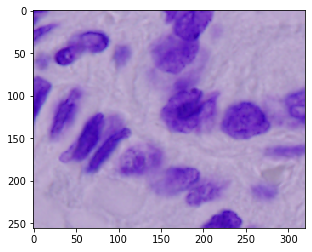

In [22]:
plt.imshow(img_array[6])
len(img_array)

In [0]:
train_mask_dict={}
mask_array=[]
for files in os.listdir('nuclei_data/stage1_train'):
    arr=0
    for file in os.listdir('nuclei_data/stage1_train/'+files+'/masks/'):
        path = 'nuclei_data/stage1_train/'+ files + '/masks/' + file
        im1=Image.open(path)
        im1= np.asarray(im1)
        mask = cv2.resize(im1, (256,256))
        arr = arr + mask
        
    train_mask_dict[files+'.png'] = arr

    mask_array.append(arr)

670

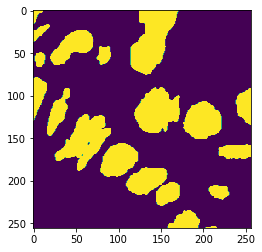

In [24]:
plt.imshow(mask_array[6])
mask_array[6].shape
len(mask_array)

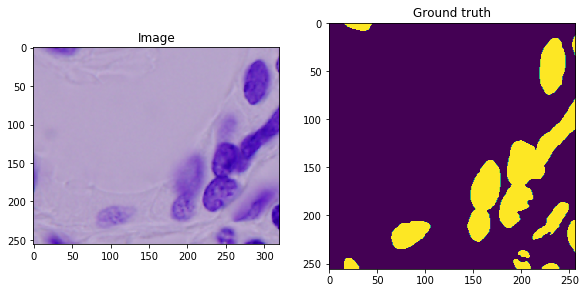

In [25]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(img_array[0])
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(mask_array[0])
plt.title('Ground truth')
plt.show()

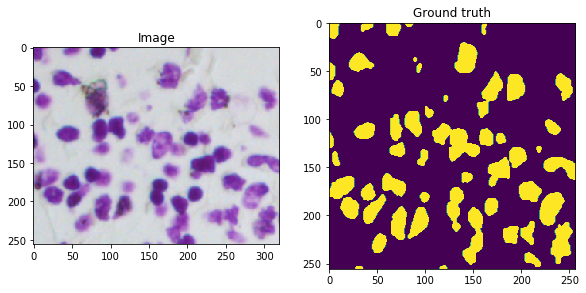

In [26]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(img_array[77])
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(mask_array[77])
plt.title('Ground truth')
plt.show()

In [0]:
def preprocessing(img,mask,SIZE):
    img = img[:,:,:3]
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
   
    img = img/255.
    mask = mask/255.
    mask = np.expand_dims(mask, axis=2)
    return (img,mask)

In [28]:
input_img=[]
output_mask=[]
for i,k in tqdm(zip(img_array,mask_array)):
    processed=preprocessing(i,k,(256,256))
    input_img.append(processed[0])
    output_mask.append(processed[1])

670it [00:01, 415.85it/s]


In [29]:
input_img[0].shape

(256, 256, 3)

In [30]:
output_mask[0].shape

(256, 256, 1)

In [0]:
input_img = np.asarray(input_img)
output_mask = np.asarray(output_mask)

In [0]:
train_img, val_img= input_img[:550], input_img[550:]
train_mask, val_mask = output_mask[:550], output_mask[550:]

In [0]:
test_img={}
test_img_id=[]
test_img_array=[]
for files in os.listdir('nuclei_data/stage1_test'):
    path = 'nuclei_data/stage1_test/'+ files + '/images/' + files +'.png'
    im = Image.open(path)
    im= np.asarray(im)
    test_img[files+'.png'] = im
    test_img_id.append(files+'.png')
    test_img_array.append(im)

In [86]:
test_img_array[7].shape

(256, 256, 4)

In [0]:
def preprocessing_test(img,SIZE):
    img = img[:,:,:3]
    img = cv2.resize(img, SIZE)
   
    img = img/255.
    return img

In [88]:
test_img_array[7].shape

(256, 256, 4)

In [37]:
test_input=[]
for i in tqdm(test_img_array):
    processed=preprocessing_test(i,(256,256))
    test_input.append(processed)

100%|██████████| 65/65 [00:00<00:00, 451.27it/s]


In [0]:
test_input=np.asarray(test_input)

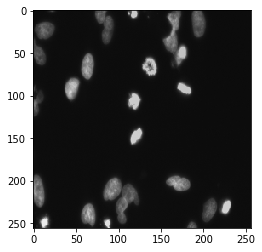

In [39]:
plt.imshow(test_input[1])

In [0]:
!mkdir model

In [0]:
from keras import models
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop

from model.losses import bce_dice_loss, dice_loss, dice_coeff

from keras.losses import binary_crossentropy
import keras.backend as K
from keras.optimizers import Adam

In [0]:
import model.u_net as unet

In [107]:
model = unet.get_unet(num_classes=1)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [108]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        activation_1[0][0]               
____________________________________________________________________________________________

In [124]:
model.fit(train_img, train_mask, epochs=50, verbose=2, validation_data=(val_img,val_mask), batch_size=1)

Train on 550 samples, validate on 120 samples
Epoch 1/50
 - 66s - loss: 0.0941 - dice_coeff: 0.9429 - val_loss: 0.2295 - val_dice_coeff: 0.8949
Epoch 2/50
 - 66s - loss: 0.0924 - dice_coeff: 0.9439 - val_loss: 0.2313 - val_dice_coeff: 0.8940
Epoch 3/50
 - 65s - loss: 0.0899 - dice_coeff: 0.9454 - val_loss: 0.2222 - val_dice_coeff: 0.8972
Epoch 4/50
 - 65s - loss: 0.0887 - dice_coeff: 0.9461 - val_loss: 0.2245 - val_dice_coeff: 0.8958
Epoch 5/50
 - 65s - loss: 0.0852 - dice_coeff: 0.9482 - val_loss: 0.2195 - val_dice_coeff: 0.8988
Epoch 6/50
 - 65s - loss: 0.0831 - dice_coeff: 0.9494 - val_loss: 0.2276 - val_dice_coeff: 0.8951
Epoch 7/50
 - 65s - loss: 0.0810 - dice_coeff: 0.9510 - val_loss: 0.2184 - val_dice_coeff: 0.9003
Epoch 8/50
 - 65s - loss: 0.0795 - dice_coeff: 0.9517 - val_loss: 0.2302 - val_dice_coeff: 0.8955
Epoch 9/50
 - 65s - loss: 0.0776 - dice_coeff: 0.9527 - val_loss: 0.2324 - val_dice_coeff: 0.8995
Epoch 10/50
 - 65s - loss: 0.0763 - dice_coeff: 0.9538 - val_loss: 0.228

KeyboardInterrupt: ignored

In [0]:
model.save_weights('nuclei_segmentation_weights.h5')

In [0]:
model.load_weights('nuclei_segmentation_weights.h5')

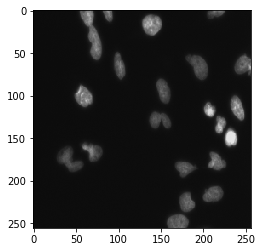

In [127]:
plt.imshow(test_input[0])

In [0]:
pred=model.predict(test_input[0].reshape(-1,256,256,3))

In [129]:
pred.shape

(1, 256, 256, 1)

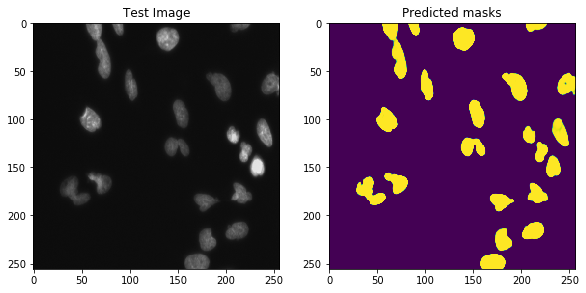

In [130]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(test_input[0])
plt.title('Test Image')
plt.subplot(1,3,2)
plt.imshow(pred.reshape(256,256))
plt.title('Predicted masks')
plt.show()

In [0]:
pred=model.predict(test_input[1].reshape(-1,256,256,3))

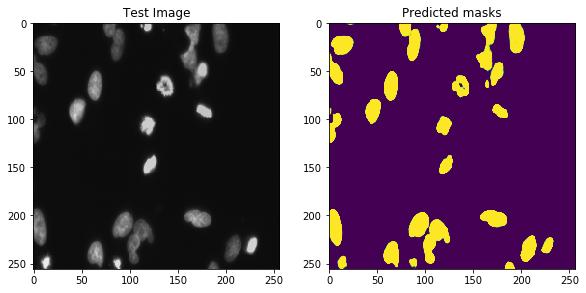

In [133]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(test_input[1])
plt.title('Test Image')
plt.subplot(1,3,2)
plt.imshow(pred.reshape(256,256))
plt.title('Predicted masks')
plt.show()

In [0]:
pred = model.predict(test_input[7].reshape(-1, 256, 256, 3))

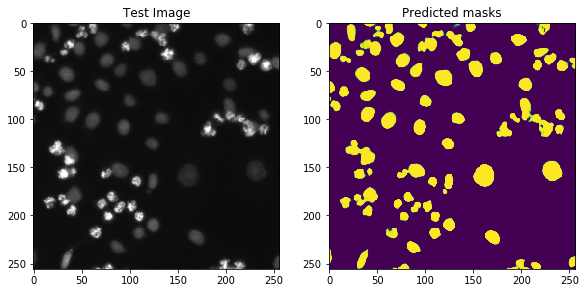

In [135]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(test_input[7])
plt.title('Test Image')
plt.subplot(1,3,2)
plt.imshow(pred.reshape(256,256))
plt.title('Predicted masks')
plt.show()

In [0]:
pred = model.predict(test_input[19].reshape(-1, 256, 256, 3))

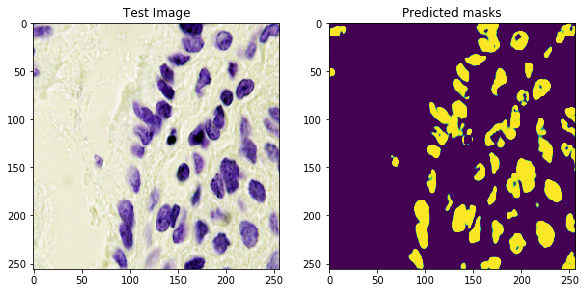

In [137]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(test_input[19])
plt.title('Test Image')
plt.subplot(1,3,2)
plt.imshow(pred.reshape(256,256))
plt.title('Predicted masks')
plt.show()